<a href="https://colab.research.google.com/github/DaryaVish/first-project/blob/main/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D1%82%D0%BE%D0%BD%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D0%B8_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0_%D1%81_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация тональности текста с BERT
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
Задача обучить модель классифицировать комментарии на позитивные и негативные на наборе данных с разметкой о токсичности правок.

In [ ]:
!pip install catboost -q
!pip install bert-tensorflow -q
!pip install transformers -q
!pip install wordcloud -q
!pip install Pillow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 4.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import transformers
import transformers as ppb
import re
import nltk
import string
import matplotlib.pyplot as plt

from pymystem3 import Mystem
from sklearn.metrics import ConfusionMatrixDisplay
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (train_test_split, RandomizedSearchCV)
from sklearn.metrics import (f1_score, confusion_matrix)
from tqdm import tqdm
from scipy.stats import uniform
from wordcloud import WordCloud

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords

from tqdm import notebook


%matplotlib inline


RANDOM_STATE = 42


In [ ]:
tqdm.pandas()

Загрузим датасет и взглянем на данные

In [ ]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=0)
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Датасет представляет собой строки на английском языке со знаками препинания и использованием верхнего и нижнего регистра. Состоит из двух признаков: комментария 'text' и целевого признака 'toxic'. Целевой признак переведём в булев тип.

In [ ]:
df['toxic'] = df['toxic'].astype(bool)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 2.6+ MB


Очистим текст от знаков препинания

In [ ]:
def clear_text(text):
  cleared_text = ' '.join(re.sub(r"http\S+|www\S+\#\S+|@\S+", " ", text).split())
  cleared_text = re.sub(r"[^a-zA-Z.'\s]", " ", cleared_text)
  return ' '.join(cleared_text.split())

In [ ]:
df['text'] = df['text'].progress_apply(clear_text)
df['text']

100%|██████████| 159292/159292 [00:09<00:00, 17225.40it/s]


,text
0,Explanation Why the edits made under my userna...
1,D'aww He matches this background colour I'm se...
2,Hey man I'm really not trying to edit war. It'...
3,More I can't make any real suggestions on impr...
4,You sir are my hero. Any chance you remember w...
...,...
159446,And for the second time of asking when your vi...
159447,You should be ashamed of yourself That is a ho...
159448,Spitzer Umm theres no actual article for prost...
159449,And it looks like it was actually you who put ...


In [ ]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

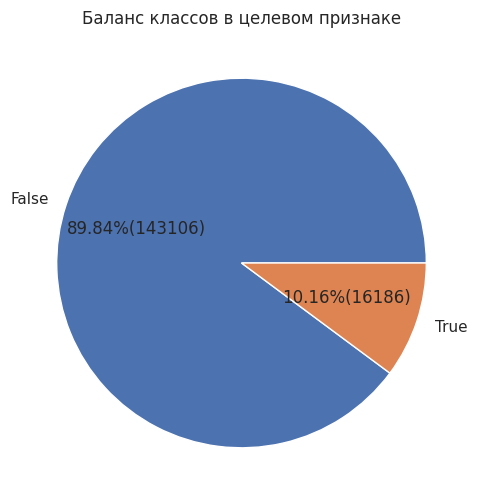

In [ ]:
ratio = df.groupby('toxic').size()

sns.set()
ratio.plot(kind='pie', title='Баланс классов в целевом признаке', figsize=[6,6],
          autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*ratio.sum()))
plt.show()

В данных очень серьёзный дисбаланс классов: токсичных комментариев 10% против 90% обычных.

Разделим данные на 3 выборки

In [ ]:
train_df, test = train_test_split(df, test_size=0.2, stratify=df['toxic'], random_state=RANDOM_STATE)
train, val = train_test_split(train_df, test_size=0.25, stratify=train_df['toxic'], random_state=RANDOM_STATE)

Готово! Можно обучать CatBoostClassifier. Сформируем для модели train set и eval set.

In [ ]:
X = ['text']
text_features = ['text']
y = ['toxic']

In [ ]:
display(train.shape)
display(val.shape)
display(test.shape)

(95574, 2)

(31859, 2)

(31859, 2)

In [ ]:
params = {'eval_metric':'AUC',
          'learning_rate': 0.15,
          'text_features':text_features,
          'verbose': 100
          }

In [ ]:
model = CatBoostClassifier(**params)

In [ ]:
model.fit(train[X], train[y], eval_set=(val[X], val[y]))

0:	test: 0.8130667	best: 0.8130667 (0)	total: 565ms	remaining: 9m 24s
100:	test: 0.9525674	best: 0.9525674 (100)	total: 37.8s	remaining: 5m 36s
200:	test: 0.9555231	best: 0.9555231 (200)	total: 1m 10s	remaining: 4m 41s
300:	test: 0.9566226	best: 0.9566380 (298)	total: 1m 46s	remaining: 4m 7s
400:	test: 0.9574715	best: 0.9574987 (399)	total: 2m 22s	remaining: 3m 32s
500:	test: 0.9577980	best: 0.9578755 (475)	total: 2m 56s	remaining: 2m 55s
600:	test: 0.9580431	best: 0.9581206 (591)	total: 3m 28s	remaining: 2m 18s
700:	test: 0.9581754	best: 0.9582142 (658)	total: 4m 1s	remaining: 1m 42s
800:	test: 0.9583243	best: 0.9584457 (780)	total: 4m 33s	remaining: 1m 8s
900:	test: 0.9583532	best: 0.9584457 (780)	total: 5m 5s	remaining: 33.6s
999:	test: 0.9583790	best: 0.9584780 (918)	total: 5m 38s	remaining: 0us

bestTest = 0.9584780051
bestIteration = 918

Shrink model to first 919 iterations.


In [ ]:
val['y_score'] = model.predict_proba(val[X])[:,1]

In [ ]:
val

,text,toxic,y_score
47109,Image copyright problem with Image Mwse.JPG Th...,False,0.001746
154472,Please do not add commercial links to wikipedi...,False,0.007100
114145,See Marine Security Guard.,False,0.012037
118851,June UTC I think it must be getting overloaded...,False,0.003592
147082,Where can i find the murder charges the french...,False,0.003333
...,...,...,...
4603,FIND SOMEONE TO MAKE LOVE TO,False,0.500208
117810,ok i didn't know that I will bear it in mind f...,False,0.034915
156945,All of you can SUCK IT,True,0.951723
82134,Re I don't understand you anymore. Until now i...,False,0.020240


Подберем порог

In [ ]:
true_labels = val['toxic']
predicted_probabilities = val['y_score']

thresholds = np.linspace(0, 1, 101)
f1_scores = []
for threshold in thresholds:
  predicted_labels = (predicted_probabilities >= threshold).astype(int)
  f1 = f1_score(true_labels, predicted_labels)
  f1_scores.append(f1)

max_f1_index = np.argmax(f1_scores)
optimal_threshold = thresholds[max_f1_index]
max_f1_score = f1_scores[max_f1_index]

optimal_threshold, max_f1_score

(0.31, 0.7526121696373694)

# BERT

Воспользуемся предобученной моделью Bert. Для быстроты возьмём часть данных, ограничимся 2 тысячами строк.

In [ ]:
batch_1 = df[:2000]

model = transformers.AutoModel.from_pretrained('unitary/toxic-bert')
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'unitary/toxic-bert')

tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')
tokenized = batch_1['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True)))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
attention_mask.shape

(2000, 512)

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
model = model_class.from_pretrained(pretrained_weights)
model.to(device)

batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
    attention_mask_batch = torch.LongTensor(
        attention_mask[batch_size*i:batch_size*(i+1)]
    ).to(device)

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

X = np.concatenate(embeddings)
y = batch_1['toxic']

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
y.shape

(2000,)

Разделим

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RANDOM_STATE)

In [ ]:
logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=100,
                              random_state=RANDOM_STATE)
distributions = dict(C=uniform(loc=0, scale=4),
                     penalty=['l2', 'l1'])
clf = RandomizedSearchCV(logistic, distributions, random_state=RANDOM_STATE, scoring='f1', cv=3, n_iter=5)
clf.fit(X_train, y_train)


clf.best_score_

0.9027751466657045

f1 метрика получается высокой 0.90.

Взглянем на матрицу ошибок

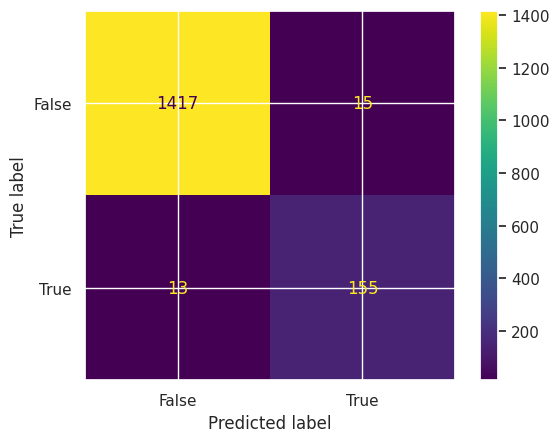

In [ ]:
predictions = clf.predict(X_train)
cm = confusion_matrix(y_train, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

модель хорошо отличает токсичные комментарии от не токсичных, большой дисбаланс классов в данных

Сравним как справились модели

In [ ]:
model_data = {
'model_name': ['CatBoost', 'LogisticRegression'],
'f1': [round(max_f1_score, 2), round(clf.best_score_, 2)]
}

model_table = pd.DataFrame.from_dict(model_data)
model_table

,model_name,f1
0,CatBoost,0.75
1,LogisticRegression,0.90


Логистическая регрессия вместе в BERT показала лучший результат на тренировочной выборке, ее и возмём на финальное тестирование.

# Проверка лучшей модели на тесте

Проверим метрику LogisticRegression на тестовой выборке

In [ ]:
print(f1_score(y_test, clf.predict(X_test)))

0.963855421686747


Модель логистической регресии показала f1 96% на тесте.

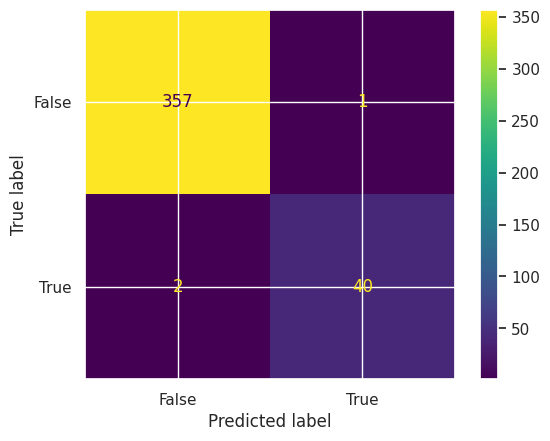

In [ ]:
predictions_test = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions_test, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

Модель очень хорошо различает токсичные и обычные комментарии.

# Вывод

Датасет представляет собой строки на английском языке со знаками препинания и использованием верхнего и нижнего регистра. Состоит из двух признаков: комментария 'text' и целевого признака 'toxic'. Целевой признак переведём в булев тип.

В данных очень серьёзный дисбаланс классов: токсичных комментариев 10% против 90% обычных.


Обучили 2 модели:


*   в качестве первой я использовала CatBoostClassifier, с помощью подбора порога удалось достичь метрики f1 0.75;
*   в качестве второй я взяла предобученную на токсичных словах модель Bert. Для быстроты ограничила данные 2 тысячами строк, в качестве модели для предсказаний использовала LogisticRegression. f1 метрика получается достаточно высокой 0.90.


С помощью матрицы ошибок оценила ответы: модель хорошо отличает токсичные комментарии от не токсичных, большой дисбаланс классов.

Логистическая регрессия вместе в BERT показала лучший результат на тренировочной выборке, ее и возмём на финальное тестирование.

Метрика возрасла с 90 на тренировочной выборке до 96 на тестовой.
Матрица ошибок подтвердила хороший результат, модель неправильно разметила всего 3 комментария из 400.